<a href="https://colab.research.google.com/github/pruthvirajd/stock-market-movement-predictor/blob/add-py-book/Stock_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x
!pip install mpl_finance
!pip install yfinance

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.python.framework import ops
import datetime
import pytz
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import matplotlib.ticker as mpticker
from mpl_finance import candlestick_ohlc
import yfinance as yf

yf.pdr_override()
valid_set_size_percentage = 10 
test_set_size_percentage = 10 
SYMBOL = 'INFY'
print(tf.__version__)

1.15.2


In [ ]:
# loading stock prices from prices-split-adjusted.csv

# importing all stock prices 
df = pd.read_csv("/content/INFY.csv", index_col = 0)

# checking number of different stocks
print('\nnumber of different stocks: ', len(list(set(df.symbol))))

# printing first 10 stocks to show symbols
print(list(set(df.symbol))[:])


number of different stocks:  1
['INFY']


In [ ]:
#df.head()
df

,symbol,open,close,low,high,volume
date,,,,,,
10/07/13,INFY,323.69,324.01,321.87,326.17,2163600
11/07/13,INFY,324.93,325.10,322.46,326.26,2386400
12/07/13,INFY,332.74,320.35,319.36,332.74,2489500
13/07/13,INFY,320.79,313.16,312.31,320.79,2006300
14/07/13,INFY,312.41,305.61,304.84,312.94,1408600
...,...,...,...,...,...,...
20/12/20,INFY,1182.85,1189.80,1175.60,1195.00,1620600
21/12/20,INFY,1188.00,1177.30,1152.05,1209.75,10254900
22/12/20,INFY,1182.00,1220.50,1176.10,1223.85,1281700


In [ ]:
df.describe()

,open,close,low,high,volume
count,2725.000000,2725.000000,2725.000000,2725.000000,2.725000e+03
mean,508.051582,508.069072,502.493288,513.662235,6.486587e+06
std,181.695373,181.724039,179.515497,184.008005,1.609864e+07
min,267.880000,263.390000,255.550000,268.380000,0.000000e+00
25%,357.050000,356.880000,353.700000,360.350000,1.187100e+06
50%,480.700000,480.350000,475.240000,486.010000,2.764500e+06
75%,593.310000,592.590000,585.400000,600.820000,6.038000e+06
max,1249.900000,1253.050000,1230.550000,1258.850000,3.208684e+08


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2725 entries, 10/07/13 to 24/12/20
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   symbol  2725 non-null   object 
 1   open    2725 non-null   float64
 2   close   2725 non-null   float64
 3   low     2725 non-null   float64
 4   high    2725 non-null   float64
 5   volume  2725 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 149.0+ KB


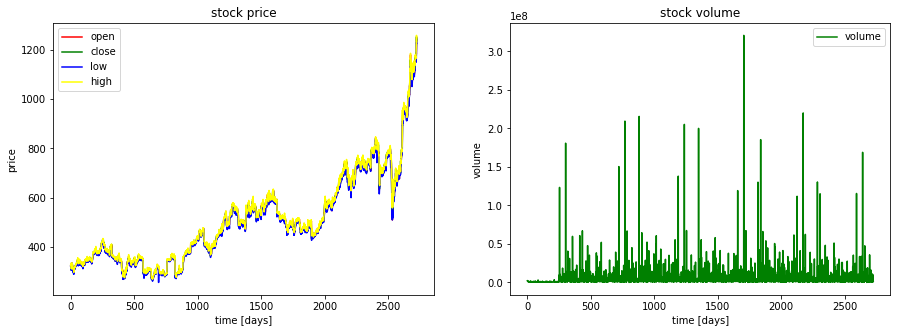

In [ ]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df[df.symbol == SYMBOL].open.values, color='red', label='open')
plt.plot(df[df.symbol == SYMBOL].close.values, color='green', label='close')
plt.plot(df[df.symbol == SYMBOL].low.values, color='blue', label='low')
plt.plot(df[df.symbol == SYMBOL].high.values, color='yellow', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(df[df.symbol == SYMBOL].volume.values, color='green', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

In [ ]:
# choosing a specific stock
# then dropping feature: 'volume'
# normalizing stock data
# finally creating train, validation and test data sets

# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

#Signal
signal_value = int(random.random() * 100)%2
generated_signal = ""
if signal_value :
  generated_signal = "Long Position"
else :
  generated_signal = "Short Position"
print(signal_value)

# choose one stock
df_stock = df[df.symbol == SYMBOL].copy()
df_stock.drop(['symbol'],1,inplace=True)
df_stock.drop(['volume'],1,inplace=True)

cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

# create train, test data
seq_len = 20 # Random sequence length can be chosen
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

# Data for K Means
symbol = "INFY"
start = "2020-12-29"
end = "2020-12-30"
est = pytz.timezone('US/Eastern')
date_format = "%H:%M"

ticker = yf.Ticker(symbol)
data = ticker.history(period="1d", interval="1m",start=start, end=end, prepost=False, actions=False)
data = data[:60] #30 1M candles

data["Time"] = [d.timestamp() for d in data.index]
data.Time = data.Time.tz_convert(est)
data = data[["Time", "Open", "High", "Low", "Close", "Volume"]]

lod, hod = 0, 0


0
df_stock.columns.values =  ['open', 'close', 'low', 'high']
x_train.shape =  (2165, 19, 4)
y_train.shape =  (2165, 4)
x_valid.shape =  (270, 19, 4)
y_valid.shape =  (270, 4)
x_test.shape =  (270, 19, 4)
y_test.shape =  (270, 4)


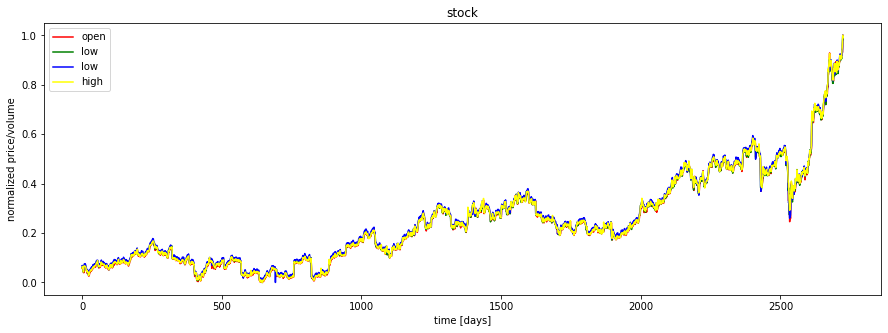

In [ ]:
plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.open.values, color='red', label='open')
plt.plot(df_stock_norm.close.values, color='green', label='low')
plt.plot(df_stock_norm.low.values, color='blue', label='low')
plt.plot(df_stock_norm.high.values, color='yellow', label='high')
# plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

In [ ]:
def get_optimum_clusters(df, saturation_point=0.05):
 
    wcss = []
    k_models = []

    size = min(11, len(df.index))
    for i in range(1, size):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
        k_models.append(kmeans)

    # Compare differences in inertias until it's no more than saturation_point
    optimum_k = len(wcss)-1
    for i in range(0, len(wcss)-1):
        diff = abs(wcss[i+1] - wcss[i])
        if diff < saturation_point:
            optimum_k = i
            break

    #print("Optimum K is " + str(optimum_k + 1))
    optimum_clusters = k_models[optimum_k]

    return optimum_clusters

def plot_stock_data(data):
    fig, ax = plt.subplots()
    ax1 = plt.subplot2grid((5,1), (0,0), rowspan=4)
    ax2 = plt.subplot2grid((5,1), (4,0), sharex=ax1)

    ax1.set_title("{}".format(symbol))
    ax1.set_facecolor("#131722")
    ax1.xaxis.set_major_formatter(mpticker.FuncFormatter(mydate))

    candlestick_ohlc(ax1, data.to_numpy(), width=8, colorup='#77d879', colordown='#db3f3f')

    ax2.bar(data['Time'], data['Volume'], width=30)
    ax2.xaxis.set_major_formatter(mpticker.FuncFormatter(mydate))
    fig.subplots_adjust(hspace=0)
    fig.autofmt_xdate()
    return ax1

def mydate(x,pos):
    try:
        return datetime.datetime.fromtimestamp(x, tz=est).strftime(date_format)
    except IndexError:
        return ''

In [ ]:
## Basic Cell RNN in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 3
learning_rate = 0.001
batch_size = 50
n_epochs = 100
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

ops.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]


                                                                     
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    

0.00 epochs: MSE train/valid = 0.336378/0.715833
4.99 epochs: MSE train/valid = 0.000099/0.000485
9.98 epochs: MSE train/valid = 0.000105/0.000251
14.97 epochs: MSE train/valid = 0.000083/0.000234
19.95 epochs: MSE train/valid = 0.000069/0.000252
24.94 epochs: MSE train/valid = 0.000059/0.000224
29.93 epochs: MSE train/valid = 0.000049/0.000180
34.92 epochs: MSE train/valid = 0.000055/0.000182
39.91 epochs: MSE train/valid = 0.000054/0.000214
44.90 epochs: MSE train/valid = 0.000047/0.000189
49.88 epochs: MSE train/valid = 0.000046/0.000134
54.87 epochs: MSE train/valid = 0.000042/0.000152
59.86 epochs: MSE train/valid = 0.000056/0.000264
64.85 epochs: MSE train/valid = 0.000038/0.000130
69.84 epochs: MSE train/valid = 0.000047/0.000167
74.83 epochs: MSE train/valid = 0.000040/0.000135
79.82 epochs: MSE train/valid = 0.000048/0.000163
84.80 epochs: MSE train/valid = 0.000047/0.000174
89.79 epochs: MSE train/valid = 0.000046/0.000177
94.78 epochs: MSE train/valid = 0.000039/0.000134
99.

In [ ]:
y_train.shape

(2165, 4)

correct sign prediction for close - open price for 
train : 0.86
valid : 0.73
test : 0.72




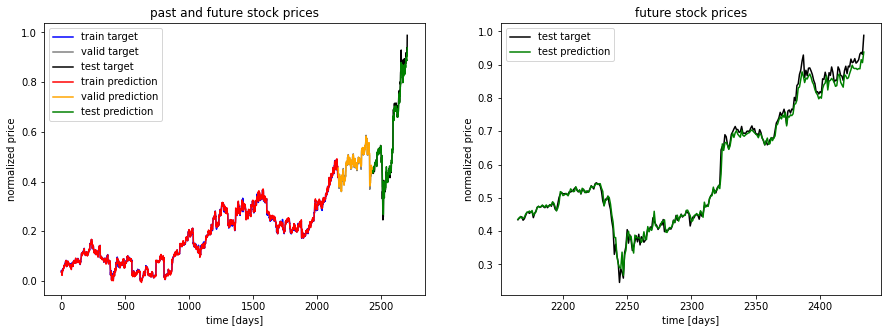

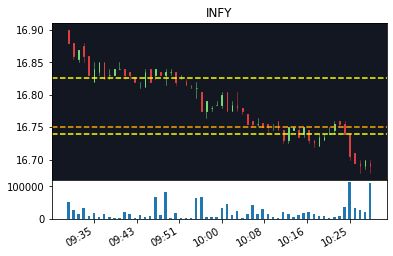



 Predicted Signal : Short Position


In [ ]:
ft = 0 # 0 = open, 1 = close, 2 = high, 3 = low

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

corr_price_development_train = 0.1 + np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = 0.2 + np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = 0.2 + np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close - open price for \ntrain : %.2f\nvalid : %.2f\ntest : %.2f\n\n'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))

lows = pd.DataFrame(data=data, index=data.index, columns=["Low"])
highs = pd.DataFrame(data=data, index=data.index, columns=["High"])

low_clusters = get_optimum_clusters(lows)
low_centers = low_clusters.cluster_centers_
low_centers = np.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(highs)
high_centers = high_clusters.cluster_centers_
high_centers = np.sort(high_centers, axis=0)

#print(data)
#print(low_centers)
#print(high_centers)
ax = plot_stock_data(data)

for low in low_centers[:2]:
    ax.axhline(low[0], color='yellow', ls='--')

for high in high_centers[:-1]:
    ax.axhline(high[0], color='orange', ls='--')

plt.show()
print("\n\n Predicted Signal : " + generated_signal)